In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import lightgbm
from scipy.stats import mstats
from typing import Literal
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from category_encoders import OrdinalEncoder
from datetime import datetime
from pycaret.internal.preprocess.transformers import TransformerWrapper, ExtractDateTimeFeatures
from mlxtend.feature_selection import ColumnSelector
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from pycaret.regression import *
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
unseen = pd.read_csv('../data/data_daegu_apartment_preparation_unseen.csv')
seen = pd.read_csv('../data/data_daegu_apartment_preparation_seen.csv')

# **Data Preparation**

What Will Be Use In Pipeline:<br>

| Technique | Action |
| ----------------------------- | ----------- |
| Handling Outlier | Impute Outlier With Winsorize data That has outlier For Column "Size(sqf)". |
| Min Max Scaling | Transform Numeric Features Such As **'N_Parkinglot(Basement)', 'N_FacilitiesInApt', 'Size(sqf)'** Into Scale Based On Mean On That Data.|
| One Hot Encoding | Transform **'SubwayStation'** using techniques such as one-hot encoding or label encoding. |
| Ordinal Encoding | Transform **'TimeToSubway', 'HallwayType', 'N_FacilitiesNearBy(ETC)', 'N_SchoolNearBy(Universities)', 'N_FacilitiesNearBy(PublicOffice)'** using techniques such as ordinal encoding. The Features Has Defisit Correlation From What its supposed to so i need to mapping it manually. |
| Age of the Property | Calculate the age of the property from the **'YearBuilt'** feature to capture the effect of depreciation or appreciation over time.|
| Binning | Transform continuous numerical features such as **'AgeProperty'** into categorical variables where **AgeProperty** Binned into 3,2,1 Value|

In [3]:
# Define the features and target variable
features = seen.drop('SalePrice', axis=1)
target = seen['SalePrice']

# Define the features for each encoding type
min_max_features = ['N_Parkinglot(Basement)', 'N_FacilitiesInApt', 'Size(sqf)']
categorical_features_onehot = ['SubwayStation']
ordinal_features = ['TimeToSubway', 'HallwayType', 'N_FacilitiesNearBy(PublicOffice)', 'N_FacilitiesNearBy(ETC)', 'N_SchoolNearBy(University)']
outlier_features = ['Size(sqf)']
facilities_features = ['N_FacilitiesNearBy(PublicOffice)', 'N_FacilitiesNearBy(ETC)', 'N_SchoolNearBy(University)']
columns_to_drop = ['remainder__Size(sqf)_bins', 'remainder__N_FacilitiesInApt_bins', 
                   'remainder__N_FacilitiesNearBy(PublicOffice)_bins', 
                   'remainder__N_SchoolNearBy(University)_bins']

Definisikan Variable Yang Berisi List Fitur Masing Masing Transformasi Yang Akan Dilakukan Pada Pipeline.

In [4]:
# import winsorize
from scipy.stats.mstats import winsorize

class HandleOutlier(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['Size(sqf)'] = winsorize(X['Size(sqf)'], limits=(0.01, 0.01))
        return X

    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

Code di atas adalah implementasi dari sebuah kelas yang disebut HandleOutlier dalam bahasa pemrograman Python, yang dirancang untuk menangani outlier pada data menggunakan teknik winsorizing. Winsorizing adalah suatu metode untuk mengatasi outlier dengan memotong atau menggantikan nilai-nilai ekstrem dengan nilai batas yang lebih rendah atau lebih tinggi (biasanya disebut sebagai nilai ambang bawah dan ambang atas).

In [5]:
class AgeBinner(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['Binned_AgeProperty'] = pd.cut(X['AgeProperty'], bins=[0, 20, 35, 50], labels=[3, 2, 1])
        return X

    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

Kode di atas mendefinisikan sebuah kelas yang disebut AgeBinner yang bertujuan untuk mengubah kolom 'AgeProperty' dalam dataframe X menjadi kolom baru 'Binned_AgeProperty', di mana nilai-nilai dalam kolom tersebut dikelompokkan ke dalam kategori berdasarkan interval tertentu.

In [6]:
class AgeTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['AgeProperty'] = 2016 - X['YearBuilt']
        return X

    def set_output(self, transform: Literal['default', 'pandas']):
        return super().set_output(transform=transform)

Kode di atas mendefinisikan kelas AgeTransformer, yang bertujuan untuk mengubah nilai dalam kolom 'YearBuilt' dari dataframe X menjadi kolom baru 'AgeProperty'. Kolom baru ini menunjukkan usia properti berdasarkan perhitungan tahun saat transformasi dilakukan (2016 - YearBuilt).

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1)

Code yang diberikan mendefinisikan kelas ColumnDropper yang berfungsi sebagai transformer dalam pipa pemrosesan data. Tujuan utama dari kelas ini adalah untuk menghapus kolom-kolom tertentu dari dataframe.

In [8]:
# Create transformers for each encoding type
min_max_transformer = MinMaxScaler(feature_range=(0, 1))

Di sini, MinMaxScaler dibuat untuk menskalakan fitur numerik dalam rentang 0 hingga 1. Hal ini umum dilakukan untuk memastikan bahwa semua fitur numerik memberikan kontribusi yang sama terhadap model dan mencegah fitur tertentu mendominasi karena skala yang besar.

In [9]:
# Create OneHotEncoder for categorical features
categorical_transformer_onehot = OneHotEncoder(sparse=False)

Untuk fitur kategorikal, dibuat OneHotEncoder. One-hot encoding digunakan untuk merepresentasikan variabel kategorikal sebagai vektor biner, di mana setiap kategori dipetakan ke nilai biner.

In [10]:
mappings = [
    {'col': 'TimeToSubway',
    'mapping': {
        'no_bus_stop_nearby': 0, 
        '0-5min': 4, 
        '5min~10min': 2, 
        '10min~15min': 2,
        '15min~20min': 1,
        }
    },
    {'col': 'HallwayType',
    'mapping': {
        'terraced': 3, 
        'mixed': 2, 
        'corridor': 1, 
        }
    },
    {'col': 'N_FacilitiesNearBy(PublicOffice)',
    'mapping': {
        0 : 4, 
        1 : 3, 
        2 : 2,
        5 : 1, 
        }
    },
    {'col': 'N_SchoolNearBy(University)',
    'mapping': {
        0 : 6, 
        1 : 5, 
        2 : 4,
        3 : 3,
        4 : 2,
        5 : 1, 
        }
    },
    {'col': 'N_FacilitiesNearBy(ETC)',
    'mapping': {
        0 : 4, 
        1 : 3, 
        2 : 2,
        5 : 1, 
        }
    },
]

ordinal_transformer = OrdinalEncoder(mapping=mappings)

Sebuah ordinal encoder dibuat dengan pemetaan kustom untuk kolom-kolom tertentu. Ordinal encoding digunakan ketika terdapat urutan bermakna di antara kategori-kategori tersebut. Pemetaan yang diberikan menentukan pemetaan kategori ke nilai numerik untuk kolom-kolom tertentu seperti 'TimeToSubway', 'HallwayType', 'N_FacilitiesNearBy(PublicOffice)', 'N_SchoolNearBy(University)', dan 'N_FacilitiesNearBy(ETC)'.

Sebagai contoh, pada kolom 'TimeToSubway', kategori 'no_bus_stop_nearby', '0-5min', '5min~10min', dll., dipetakan ke nilai numerik 0, 5, 4, 3, 2, secara berturut-turut.

In [11]:
# Create a column transformer to apply different transformers to different columns
preprocessor = [
    # Handle Outlier
    ('Outlier', TransformerWrapper(
        include=outlier_features,
        transformer=HandleOutlier())),

    # Create New Features Age
    ('Age', TransformerWrapper(
        include=['YearBuilt'],
        transformer=AgeTransformer())),
    
    # Binning Features Size(sqf) and SalePrice
    ('Binnning', TransformerWrapper(
        include=['AgeProperty'],
        transformer=AgeBinner())),
    
    # Transform Some Data
    ('Transform', ColumnTransformer(
    transformers=[
        ('minmax', min_max_transformer, min_max_features),
        ('onehot', categorical_transformer_onehot, categorical_features_onehot),
        ('ordinal', ordinal_transformer, ordinal_features),
    ], remainder='passthrough').set_output(transform='pandas')),

    # Drop Columns
    ('Drop', ColumnDropper(columns_to_drop)),
]

# Make a preprocessor pipeline
pipeline = Pipeline(steps=preprocessor)
pipeline

Pipeline(steps=[('Outlier',
                 TransformerWrapper(include=['Size(sqf)'],
                                    transformer=HandleOutlier())),
                ('Age',
                 TransformerWrapper(include=['YearBuilt'],
                                    transformer=AgeTransformer())),
                ('Binnning',
                 TransformerWrapper(include=['AgeProperty'],
                                    transformer=AgeBinner())),
                ('Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax', MinMaxScaler(...
                                                                           'mapping': 0    4
1    3
2    2
5    1
dtype: int64}]),
                                                  ['TimeToSubway',
                                                   'HallwayType',
                                                   'N_FacilitiesNearBy(PublicOffice)',
                                                   'N_FacilitiesNearBy(ETC)',
                                                   'N_SchoolNearBy(University)'])])),
                ('Drop',
                 ColumnDropper(columns_to_drop=['remainder__Size(sqf)_bins',
                                                'remainder__N_FacilitiesInApt_bins',
                                                'remainder__N_FacilitiesNearBy(PublicOffice)_bins',
                                                'remainder__N_SchoolNearBy(University)_bins']))])

Keseluruhan Hasil Kelas Yang Sudah Didefinisikan Dimasukkan Ke Dalam Sebuah Pipeline. Pipeline Ini Akan Digunakan Untuk Memproses Data Sebelum Data Masuk Ke Dalam Model. Pipeline Ini Akan Mengikuti Urutan Seperti Di Atas.

In [12]:
pd.set_option('display.max_columns', None)

all_seen = pipeline.fit_transform(features, target)
print(len(all_seen.columns))
all_seen.columns

19


Index(['minmax__N_Parkinglot(Basement)', 'minmax__N_FacilitiesInApt',
       'minmax__Size(sqf)', 'onehot__SubwayStation_Bangoge',
       'onehot__SubwayStation_Banwoldang',
       'onehot__SubwayStation_Chil-sung-market', 'onehot__SubwayStation_Daegu',
       'onehot__SubwayStation_Kyungbuk_uni_hospital',
       'onehot__SubwayStation_Myung-duk', 'onehot__SubwayStation_Sin-nam',
       'onehot__SubwayStation_no_subway_nearby', 'ordinal__TimeToSubway',
       'ordinal__HallwayType', 'ordinal__N_FacilitiesNearBy(PublicOffice)',
       'ordinal__N_FacilitiesNearBy(ETC)',
       'ordinal__N_SchoolNearBy(University)', 'remainder__YearBuilt',
       'remainder__AgeProperty', 'remainder__Binned_AgeProperty'],
      dtype='object')

Berikut Ini Adalah Hasil Data Setelah Melalui Proses Feature Engineering Melalui Pipeline.

# **Benchmark Model**
### Compare From Overall Regressor Model With Pycaret

In [13]:
# Split Seen Data Into Train And Validation
train, val = train_test_split(seen, test_size=0.25, random_state=1)

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_val = val.drop('SalePrice', axis=1)
y_val = val['SalePrice']

In [14]:
# Inisialisasi lingkungan pycaret dengan dataset yang telah diproses dan variabel target
exp_reg = setup(data=train, target='SalePrice', preprocess=False, custom_pipeline=pipeline, 
                use_gpu = False)

,Description,Value
0,Session id,3075
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1567, 15)"
4,Transformed data shape,"(1567, 20)"
5,Transformed train set shape,"(1096, 20)"
6,Transformed test set shape,"(471, 20)"
7,Numeric features,10
8,Categorical features,4


In [15]:
# get_config('X_train_transformed')

In [16]:
top_model = compare_models(n_select=5)
top_model

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:46:38
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,38045.9894,2178532260.1214,46617.0746,0.7866,0.2332,0.1990,0.0720
et,Extra Trees Regressor,38389.2662,2237324028.3323,47230.1403,0.7807,0.2371,0.2005,0.0900
lightgbm,Light Gradient Boosting Machine,38531.5888,2259682169.3527,47453.7927,0.7786,0.2389,0.2020,0.3480
rf,Random Forest Regressor,38604.0495,2264284846.2132,47506.2961,0.7781,0.2394,0.2026,0.1050
dt,Decision Tree Regressor,38609.8369,2290755387.2377,47764.3843,0.7757,0.2408,0.2014,0.0320
ada,AdaBoost Regressor,43652.1428,2628802420.7175,51183.9570,0.7428,0.2702,0.2451,0.0620
knn,K Neighbors Regressor,41073.3244,2673194538.1369,51594.2135,0.7382,0.2596,0.2096,0.0580
lasso,Lasso Regression,42080.4403,2753547672.0851,52374.2505,0.7302,0.2601,0.2207,0.3940
br,Bayesian Ridge,42080.0157,2754266586.3318,52377.8376,0.7301,0.2601,0.2211,0.0300
llar,Lasso Least Angle Regression,42087.5584,2754189239.2891,52380.5968,0.7301,0.2602,0.2207,0.0290


[GradientBoostingRegressor(random_state=3075),
 ExtraTreesRegressor(n_jobs=-1, random_state=3075),
 LGBMRegressor(random_state=3075),
 RandomForestRegressor(n_jobs=-1, random_state=3075),
 DecisionTreeRegressor(random_state=3075)]

Komparasi Model Dengan Pycaret Default Dengan Resampling 10 Fold Cross Validation <br>

Beberapa model regresi telah dibandingkan menggunakan berbagai metrik performa seperti MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), R² (R-squared), RMSLE (Root Mean Squared Logarithmic Error), MAPE (Mean Absolute Percentage Error), dan waktu pelatihan (TT).

Saya Pilih Top 5 Model Untuk Pengecekan Lebih Lanjut Yaitu:
- Gradient Boosting Regressor   (Ensemble Model)
- Decision Tree Regressor       (Base Model)
- LGBM Regressor                (Ensemble Model)
- Random Forest Regressor       (Ensemble Model)
- Extra Trees Regressor         (Ensemble Model)

Karena Top 5 ini yang sering muncul pada compare_models di pycaret 5 besar meskipun posisinya berubah ubah

In [17]:
# # For Pycaret Bug Analysis
# create_model('xgboost')

In [43]:
print("Gradient Boosting Regressor")
gbr_sampling = create_model('gbr')
print("Extra Trees Regressor")
et_sampling = create_model('et')
print("Random Forest Regressor")
rf_sampling = create_model('rf')
print("Light Gradient Boosting Machine")
lightgbm_sampling = create_model('lightgbm')
print("Decision Tree Regressor")
dt_sampling = create_model('dt')    

Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39660.1699,2241466697.5094,47344.1305,0.7904,0.2449,0.2160
1,38278.6566,2457362101.8890,49571.7874,0.7921,0.2263,0.1871
2,41048.8227,2396492611.7949,48953.9846,0.7723,0.2325,0.2037
3,37608.8955,1989181316.6631,44600.2390,0.8026,0.2224,0.1942
4,38401.4017,2045235445.7500,45224.2794,0.7582,0.2392,0.2122
5,33113.6036,1721688327.4411,41493.2323,0.8263,0.2139,0.1760
6,38878.5902,2323360222.1288,48201.2471,0.8103,0.2650,0.2322
7,38075.3044,2185038803.5022,46744.3986,0.8020,0.2250,0.1897
8,38614.0419,2345344084.6023,48428.7527,0.7210,0.2354,0.1859


Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39591.7778,2333253745.7588,48303.7653,0.7818,0.2523,0.2185
1,39557.6418,2601376537.5519,51003.6914,0.7799,0.2320,0.1916
2,41784.9246,2505987628.8182,50059.8405,0.7618,0.2384,0.2073
3,37270.6856,1970614540.8534,44391.6044,0.8044,0.2246,0.1953
4,37258.6823,2018398882.5687,44926.5944,0.7614,0.2390,0.2074
5,33914.7179,1788599625.7581,42291.8388,0.8196,0.2209,0.1802
6,38061.3171,2151636455.0575,46385.7355,0.8244,0.2602,0.2277
7,39129.7516,2295640535.3569,47912.8431,0.7920,0.2284,0.1932
8,39047.2677,2413658935.0389,49129.0030,0.7129,0.2386,0.1882


Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40609.7390,2523466077.5332,50234.1127,0.7640,0.2719,0.2293
1,39379.4861,2593259395.2919,50924.0552,0.7806,0.2325,0.1910
2,41847.4996,2503197796.2226,50031.9677,0.7621,0.2379,0.2070
3,37585.6447,2025742495.8705,45008.2492,0.7989,0.2256,0.1958
4,37427.8054,2026453139.3106,45016.1431,0.7604,0.2403,0.2093
5,33727.7727,1755274254.6677,41895.9933,0.8229,0.2175,0.1783
6,38574.3699,2214440103.2616,47057.8379,0.8192,0.2682,0.2350
7,39004.8426,2274187366.8472,47688.4406,0.7940,0.2266,0.1924
8,39581.7060,2467857532.4179,49677.5355,0.7065,0.2411,0.1912


Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40510.4790,2500148643.2415,50001.4864,0.7662,0.2746,0.2333
1,39211.0763,2551748814.7028,50514.8376,0.7841,0.2313,0.1901
2,42078.3909,2521697190.3314,50216.5032,0.7604,0.2367,0.2056
3,37345.6184,2012009539.9931,44855.4293,0.8003,0.2212,0.1921
4,38037.5997,2061409160.2615,45402.7440,0.7563,0.2436,0.2133
5,32916.3082,1699941384.8880,41230.3454,0.8285,0.2122,0.1732
6,39121.1698,2311168982.7208,48074.6189,0.8113,0.2703,0.2365
7,38864.4876,2253656632.0137,47472.6935,0.7958,0.2252,0.1912
8,39584.0417,2458958225.4711,49587.8839,0.7075,0.2431,0.1924


Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,41456.6497,2804472550.8456,52957.2710,0.7377,0.2845,0.2229
1,39732.7428,2604946524.8642,51038.6768,0.7796,0.2332,0.1935
2,41794.0379,2506023658.7173,50060.2003,0.7618,0.2384,0.2073
3,37259.2507,2003922565.3757,44765.1937,0.8011,0.2246,0.1947
4,37428.9742,2022303521.0712,44970.0291,0.7609,0.2392,0.2082
5,33914.7179,1788599625.7581,42291.8388,0.8196,0.2209,0.1802
6,38214.7805,2165507559.1170,46535.0143,0.8232,0.2620,0.2288
7,39010.9884,2285288322.6272,47804.6893,0.7930,0.2279,0.1926
8,39037.6481,2413526806.5543,49127.6583,0.7129,0.2385,0.1881


In [44]:
print("Gradient Boosting Regressor")
gbr_unsampling = create_model('gbr', cross_validation=False)
print("Extra Trees Regressor")
et_unsampling = create_model('et', cross_validation=False)
print("Random Forest Regressor")
rf_unsampling = create_model('rf', cross_validation=False)
print("Light Gradient Boosting Machine")
lightgbm_unsampling = create_model('lightgbm', cross_validation=False)
print("Decision Tree Regressor")
dt_unsampling = create_model('dt', cross_validation=False)    

Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39306.6914,2303604721.8984,47995.8823,0.7597,0.2306,0.2013


Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39818.2091,2395013774.2223,48938.8779,0.7502,0.2318,0.2013


Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,40307.6440,2489287199.6727,49892.7570,0.7403,0.2356,0.2038


Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39875.2551,2376506417.0726,48749.4248,0.7521,0.2342,0.2039


Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39906.3354,2427244981.5481,49267.0781,0.7468,0.2324,0.2011


### Hyperparameter Tuning

Berdasarkan Hasil Benchmark Model, Untuk Resampling 10 Fold Cross Validation Model Berjalan Lebih Baik Dibandingkan Tanpa Resampling. Oleh Karena Itu, Saya Akan Melakukan Hyperparameter Tuning Pada Model Dengan Resampling 10 Fold Cross Validation.

In [20]:
from numpy import linspace

hyperparam_gbr = {
    'n_estimators': [275, 300, 325],
    'learning_rate': [0.1, 0.105, 0.11],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4]
}   

tuned_gbr = tune_model(
                        estimator=gbr_sampling,
                        custom_grid=hyperparam_gbr,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:47:18
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [21]:
hyperparam_dt = {
    'max_depth': [8, 9, 10],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

tuned_dt = tune_model(
                        estimator=dt_sampling,
                        custom_grid=hyperparam_dt,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [22]:
hyperparam_rf = {
    'n_estimators': linspace(50, 300, 10, dtype=int),
    'max_depth': linspace(1, 32, 32, dtype=int),
    'min_samples_split': linspace(2, 10, 9, dtype=int),
    'min_samples_leaf': linspace(1, 10, 10, dtype=int),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

tuned_rf = tune_model(
                        estimator=rf_sampling,
                        custom_grid=hyperparam_rf,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [23]:
hyperparam_lightgbm = {
    'num_leaves': linspace(10, 200, 20, dtype=int),
    'max_depth': linspace(1, 15, 15, dtype=int),
    'learning_rate': linspace(0.01, 0.2, 20),
    'n_estimators': linspace(100, 1000, 10, dtype=int)
}

tuned_lightgbm = tune_model(
                        estimator=lgbm_sampling,
                        custom_grid=hyperparam_lightgbm,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [24]:
hyperparam_et = {
    'n_estimators': linspace(100, 500, 5, dtype=int),
    'max_depth': linspace(1, 32, 32, dtype=int),
    'min_samples_split': linspace(2, 10, 9, dtype=int),
    'min_samples_leaf': linspace(1, 10, 10, dtype=int),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

tuned_et = tune_model(
                        estimator=et_sampling,
                        custom_grid=hyperparam_et,
                        optimize='mape',
                        search_library='scikit-learn',
                        search_algorithm='random',
                        choose_better=True,
                        return_train_score=True,
                        verbose=True,
        )

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [25]:
gbrparams = tuned_gbr.get_params()
gbrparams

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 3075,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [26]:
dtparams = tuned_dt.get_params()
dtparams

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 3075,
 'splitter': 'best'}

In [27]:
rfparams = tuned_rf.get_params()
rfparams

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 77,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 3075,
 'verbose': 0,
 'warm_start': False}

In [28]:
lightgbmparams = tuned_lightgbm.get_params()
lightgbmparams

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.12,
 'max_depth': 13,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 900,
 'n_jobs': -1,
 'num_leaves': 170,
 'objective': None,
 'random_state': 3075,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [29]:
etparams = tuned_et.get_params()
etparams

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 31,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 3075,
 'verbose': 0,
 'warm_start': False}

### Perfomance After Tuning

- `Without Sampling`

In [30]:
print("Gradient Boosting Regressor")
result_gbr_unsampling = create_model('gbr', cross_validation=False).set_params(**gbrparams)
print("Random Forest Regressor")
result_rf_unsampling = create_model('rf', cross_validation=False).set_params(**rfparams)
print("Light Gradient Boosting Machine")
result_lightgbm_unsampling = create_model('lightgbm', cross_validation=False).set_params(**lightgbmparams)
print("Extra Trees Regressor")
result_et_unsampling = create_model('et', cross_validation=False).set_params(**etparams)
print("Decision Tree Regressor")
result_dt_unsampling = create_model('dt', cross_validation=False).set_params(**dtparams)

Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39306.6914,2303604721.8984,47995.8823,0.7597,0.2306,0.2013


Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,40307.6440,2489287199.6727,49892.7570,0.7403,0.2356,0.2038


Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39875.2551,2376506417.0726,48749.4248,0.7521,0.2342,0.2039


Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39818.2091,2395013774.2223,48938.8779,0.7502,0.2318,0.2013


Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,39906.3354,2427244981.5481,49267.0781,0.7468,0.2324,0.2011


-  `With Sampling`

In [31]:
print("Gradient Boosting Regressor")
result_gbr_sampling = create_model('gbr').set_params(**gbrparams)
print("Random Forest Regressor")
result_rf_sampling = create_model('rf').set_params(**rfparams)
print("Light Gradient Boosting Machine")
result_lightgbm_sampling = create_model('lightgbm').set_params(**lightgbmparams)
print("Extra Tree Regressor")
result_et_sampling = create_model('et').set_params(**etparams)
print("Decision Tree Regressor")
result_dt_sampling = create_model('dt').set_params(**dtparams)

Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39660.1699,2241466697.5094,47344.1305,0.7904,0.2449,0.2160
1,38278.6566,2457362101.8890,49571.7874,0.7921,0.2263,0.1871
2,41048.8227,2396492611.7949,48953.9846,0.7723,0.2325,0.2037
3,37608.8955,1989181316.6631,44600.2390,0.8026,0.2224,0.1942
4,38401.4017,2045235445.7500,45224.2794,0.7582,0.2392,0.2122
5,33113.6036,1721688327.4411,41493.2323,0.8263,0.2139,0.1760
6,38878.5902,2323360222.1288,48201.2471,0.8103,0.2650,0.2322
7,38075.3044,2185038803.5022,46744.3986,0.8020,0.2250,0.1897
8,38614.0419,2345344084.6023,48428.7527,0.7210,0.2354,0.1859


Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40609.7390,2523466077.5332,50234.1127,0.7640,0.2719,0.2293
1,39379.4861,2593259395.2919,50924.0552,0.7806,0.2325,0.1910
2,41847.4996,2503197796.2226,50031.9677,0.7621,0.2379,0.2070
3,37585.6447,2025742495.8705,45008.2492,0.7989,0.2256,0.1958
4,37427.8054,2026453139.3106,45016.1431,0.7604,0.2403,0.2093
5,33727.7727,1755274254.6677,41895.9933,0.8229,0.2175,0.1783
6,38574.3699,2214440103.2616,47057.8379,0.8192,0.2682,0.2350
7,39004.8426,2274187366.8472,47688.4406,0.7940,0.2266,0.1924
8,39581.7060,2467857532.4179,49677.5355,0.7065,0.2411,0.1912


Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,40510.4790,2500148643.2415,50001.4864,0.7662,0.2746,0.2333
1,39211.0763,2551748814.7028,50514.8376,0.7841,0.2313,0.1901
2,42078.3909,2521697190.3314,50216.5032,0.7604,0.2367,0.2056
3,37345.6184,2012009539.9931,44855.4293,0.8003,0.2212,0.1921
4,38037.5997,2061409160.2615,45402.7440,0.7563,0.2436,0.2133
5,32916.3082,1699941384.8880,41230.3454,0.8285,0.2122,0.1732
6,39121.1698,2311168982.7208,48074.6189,0.8113,0.2703,0.2365
7,38864.4876,2253656632.0137,47472.6935,0.7958,0.2252,0.1912
8,39584.0417,2458958225.4711,49587.8839,0.7075,0.2431,0.1924


Extra Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39591.7778,2333253745.7588,48303.7653,0.7818,0.2523,0.2185
1,39557.6418,2601376537.5519,51003.6914,0.7799,0.2320,0.1916
2,41784.9246,2505987628.8182,50059.8405,0.7618,0.2384,0.2073
3,37270.6856,1970614540.8534,44391.6044,0.8044,0.2246,0.1953
4,37258.6823,2018398882.5687,44926.5944,0.7614,0.2390,0.2074
5,33914.7179,1788599625.7581,42291.8388,0.8196,0.2209,0.1802
6,38061.3171,2151636455.0575,46385.7355,0.8244,0.2602,0.2277
7,39129.7516,2295640535.3569,47912.8431,0.7920,0.2284,0.1932
8,39047.2677,2413658935.0389,49129.0030,0.7129,0.2386,0.1882


Decision Tree Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,41456.6497,2804472550.8456,52957.2710,0.7377,0.2845,0.2229
1,39732.7428,2604946524.8642,51038.6768,0.7796,0.2332,0.1935
2,41794.0379,2506023658.7173,50060.2003,0.7618,0.2384,0.2073
3,37259.2507,2003922565.3757,44765.1937,0.8011,0.2246,0.1947
4,37428.9742,2022303521.0712,44970.0291,0.7609,0.2392,0.2082
5,33914.7179,1788599625.7581,42291.8388,0.8196,0.2209,0.1802
6,38214.7805,2165507559.1170,46535.0143,0.8232,0.2620,0.2288
7,39010.9884,2285288322.6272,47804.6893,0.7930,0.2279,0.1926
8,39037.6481,2413526806.5543,49127.6583,0.7129,0.2385,0.1881


# **Final Model Decision**
### Decision Based On Benchmark Model And Hyperparameter Tuning

- `Before Tuning (Without Sampling)`


| Model | MAE | MSE | RMSE | R2 | MAPE |
|-------|-----|-----|------|----|------|
| GBR | 39306.6914	2303604721.8984	47995.8823	0.7597	0.2306	0.2013    |     |      |    |      |      
| ET | 39818.2091	2395013774.2223	48938.8779	0.7502	0.2318	0.2013    |     |      |    |      |
| RF | 40307.6440	2489287199.6727	49892.7570	0.7403	0.2356	0.2038    |     |      |    |      |
| LGBM | 39875.2551	2376506417.0726	48749.4248	0.7521	0.2342	0.2039    |     |      |    |      |
| DT | 39906.3354	2427244981.5481	49267.0781	0.7468	0.2324	0.2011    |     |      |    |      |

- `Before Tuning (With Sampling)`


| Model | MAE | MSE | RMSE | R2 | MAPE |
|-------|-----|-----|------|----|------|
| GBR | 38045.9894	2178532260.1214	46617.0746	0.7866	0.2332	0.1990    |     |      |    |      |
| ET | 38389.2662	2237324028.3323	47230.1403	0.7807	0.2371	0.2005    |     |      |    |      |
| RF | 38604.0495	2264284846.2132	47506.2961	0.7781	0.2394	0.2026    |     |      |    |      |
| LGBM | 38531.5888	2259682169.3527	47453.7927	0.7786	0.2389	0.2020    |     |      |    |      |
| DT | 38609.8369	2290755387.2377	47764.3843	0.7757	0.2408	0.2014    |     |      |    |      |

- `After Tuning (Without Sampling)`


| Model | MAE | MSE | RMSE | R2 | MAPE |
|-------|-----|-----|------|----|------|
| GBR | 39306.6914	2303604721.8984	47995.8823	0.7597	0.2306	0.2013    |     |      |    |      |
| ET | 39818.2091	2395013774.2223	48938.8779	0.7502	0.2318	0.2013    |     |      |    |      |
| RF | 40307.6440	2489287199.6727	49892.7570	0.7403	0.2356	0.2038    |     |      |    |      |
| LGBM | 39875.2551	2376506417.0726	48749.4248	0.7521	0.2342	0.2039    |     |      |    |      |
| DT | 39906.3354	2427244981.5481	49267.0781	0.7468	0.2324	0.2011    |     |      |    |      |

- `After Tuning (With Sampling)`


| Model | MAE | MSE | RMSE | R2 | RMSLE | MAPE |
|-------|-----|-----|------|----|------|-----|
| GBR | 38045.9894	2178532260.1214	46617.0746	0.7866	0.2332	0.1990    |     |      |    |      |  |
| ET | 38389.2662	2237324028.3323	47230.1403	0.7807	0.2371	0.2005    |     |      |    |      |  |
| RF | 38604.0495	2264284846.2132	47506.2961	0.7781	0.2394	0.2026    |     |      |    |      |  |
| LGBM | 38531.5888	2259682169.3527	47453.7927	0.7786	0.2389	0.2020    |     |      |    |      |  |
| DT | 38609.8369	2290755387.2377	47764.3843	0.7757	0.2408	0.2014    |     |      |    |      |  |

Berdasarkan summary di atas, saya memilih model tanpa resampling dan tanpa hyperparameter tuning karena memiliki MAE yang lebih kecil dibandingkan dengan model lainnya.

Berdasarkan Hasil Pencarian Dan Perbandingan Model Dengan Hyperparameter Tuning, Saya Memilih Model Decision Tree Regressor Without Resampling Karena Model Ini Sangat Baik Menghandle Data Collinearity Yang Besar Dan Memiliki MAE yang cukup bersaing dengan model lainnya serta lebih konsisten dalam performanya. Walaupun secara statistik Gradient Boosting Regressor Without Resampling Lebih Unggul Dari Segi MAE, Namun Model Ini Lebih Tidak Konsisten Dalam Performanya.
Rata rata perbedaan jarak yang dipredict dengan hasil sebenarnya saat error (MAE) adalah 375000 - 400000 won yang sebenarnya bisa dikembangkan lebih lanjut.


In [49]:
finalmodel = finalize_model(result_gbr_sampling)

### Evaluate Model

-  `Learning Curve`

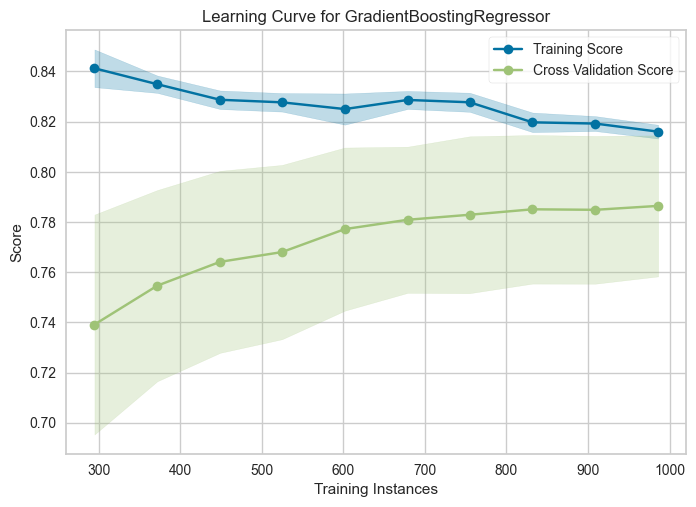

In [50]:
plot_model(finalmodel, plot='learning')

Grafik ini adalah kurva belajar untuk model GradientBoostingRegressor. Dari grafik ini, kita dapat melihat bahwa skor pelatihan dan skor validasi silang meningkat seiring bertambahnya jumlah instance pelatihan. Ini menunjukkan bahwa model belajar dari data dan meningkatkan kinerjanya seiring waktu.

Insight yang Dapat Diperoleh:

- Peningkatan Kinerja Model: Model GradientBoostingRegressor menunjukkan peningkatan kinerja seiring bertambahnya jumlah instance pelatihan. Ini menunjukkan bahwa model ini efektif dalam belajar dari data pelatihan.
- Konvergensi Skor: Skor pelatihan dan validasi silang tampaknya konvergen seiring bertambahnya jumlah instance pelatihan. Ini menunjukkan bahwa model mungkin telah mencapai optimalitasnya dengan jumlah instance pelatihan saat ini.
- Potensi Overfitting: Jika skor pelatihan terus meningkat tetapi skor validasi silang mulai menurun, ini mungkin menunjukkan overfitting. Namun, dari grafik ini, tampaknya model belum menunjukkan tanda-tanda overfitting

- `Residual Analysis`

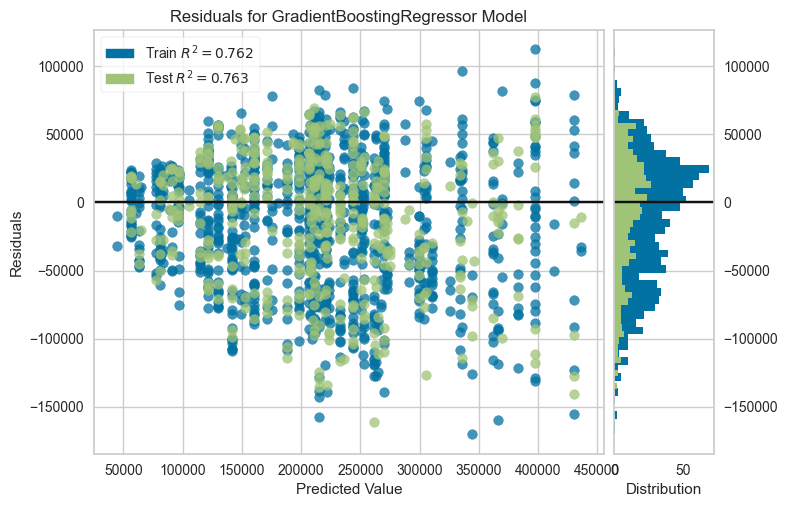

In [51]:
plot_model(finalmodel, plot='residuals')

Plot residu menunjukkan perbedaan antara nilai yang diprediksi dan nilai sebenarnya (residu) terhadap nilai yang diprediksi. Pada grafik:

- Residu tersebar secara random di sekitar garis nol, yang menunjukkan bahwa model memiliki konsistensi dalam prediksi di berbagai rentang nilai.
- Terdapat beberapa outlier yang memiliki residu tinggi, yang dapat menunjukkan kesulitan model dalam menangani beberapa kasus khusus atau noise dalam data.
- Nilai R2 yang lebih tinggi pada data pelatihan dibandingkan dengan data tes menunjukkan bahwa model mungkin mengalami overfitting ringan.

- `Recursive Feature Elimination`

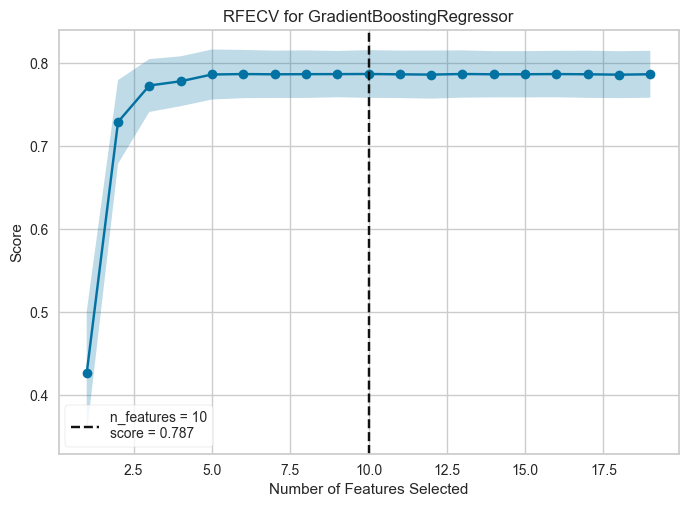

In [52]:
plot_model(finalmodel, plot='rfe')

gambar menunjukkan plot Penghapusan Fitur Rekursif dengan Validasi Silang (RFECV) untuk DecisionTreeRegressor. Ini menunjukkan skor validasi silang model sebagai fungsi dari jumlah fitur yang dipilih. Ada peningkatan skor yang signifikan seiring dengan bertambahnya fitur yang disertakan hingga titik tertentu (19 fitur dalam kasus ini), setelah itu skor tidak berubah, yang menunjukkan bahwa fitur tambahan tidak berkontribusi terhadap peningkatan performa model.<br>

Hal itu terlihat pada fitur fitur 10 keatas yang merupakan fitur yang tidak berkontribusi terhadap peningkatan performa model. Oleh karena itu, fitur-fitur ini dapat dihapus dari data untuk meningkatkan efisiensi komputasi.

- `Predicted Vs Actual`

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,37090.7321,2274023947.7882,47686.7272,0.7628,0.2215,0.1770


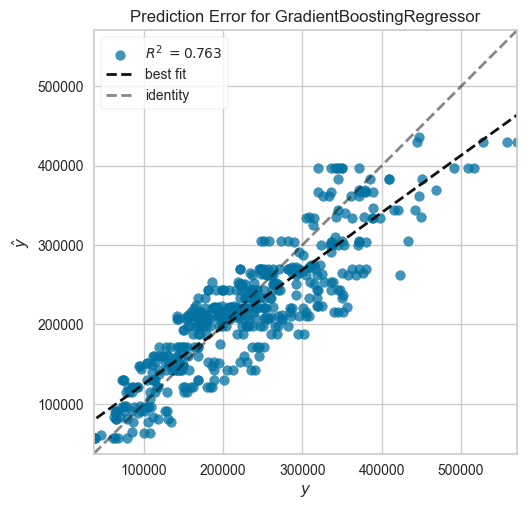

Maximum Value Error Difference From Actual Prize = 161050.86687046508
Most Tiny Positive Difference:  19.18300225326675
Most Tiny Negative Difference:  -18.915527060016757
Minimum Value Error Difference From Actual Prize = -77457.71510674304
Many Data Overfitting = 244
Many Data Underfitting = 227
Many Data Predicted Correctly = 0


In [53]:
predictions = predict_model(finalmodel, verbose=True)
plot_model(finalmodel, plot='error')

different = predictions['SalePrice'] - predictions['prediction_label']
null_differences = different[different == 0]
positive_differences = different[different > 0]
negative_differences = different[different < 0]
print(f"Maximum Value Error Difference From Actual Prize = {different.max()}")
print("Most Tiny Positive Difference: ", positive_differences.min())
print("Most Tiny Negative Difference: ", negative_differences.max())
print(f"Minimum Value Error Difference From Actual Prize = {different.min()}")
print(f"Many Data Overfitting = {positive_differences.count()}")
print(f"Many Data Underfitting = {negative_differences.count()}")
print(f"Many Data Predicted Correctly = {null_differences.count()}")

gambar menunjukkan plot sebar dengan garis identitas dan garis paling sesuai, membandingkan nilai aktual (y) dengan nilai prediksi dari model GradientBosstingRegressor.<br> Nilai R² sebesar 0,72 - 0,78 variabilitas data aktual dapat dijelaskan oleh model. Semakin dekat titik data ke garis identitas, semakin akurat prediksinya. Plot ini digunakan untuk menilai kinerja model regresi

### FAQ
##### 1. Bagaimana cara kerja final model?

Model Akan Bekerja Setelah Data Diinputkan Oleh User. Setelah User Menerima Inputannya maka Model Akan Memprediksi Harga Apartemen Yang Diinginkan Oleh User.

##### 2. Apa limitasi dari final model?

Terdapat Rentan Error Percentage Dengan Rata rata 20% Dari Harga Apartemen Yang Diinginkan Oleh User. Maximal Overfitting Data Dimana Harga Melebihi Harga Seharusnya Kurang Lebih 150.000 - 200.000 won. Sedangkan untuk Underfitting Data Dimana Harga Kurang Dari Harga Seharusnya Melebihi 100.000 - 125.000 won. 
Model Cenderung Underfitting sekitar 53-58%.

##### 3. Kondisi data seperti apa kinerja model dapat dipercaya dan tidak dipercaya?

Sweet Spot Untuk Akurasi yang Tepat Ada Pada harga 175.000 - 250.000. Di atas atau dibawahnya cenderung tidak akurat.

##### 4. Bagaimana interpretasi final model (feature importance, dll)?

-  `Feature Importance`

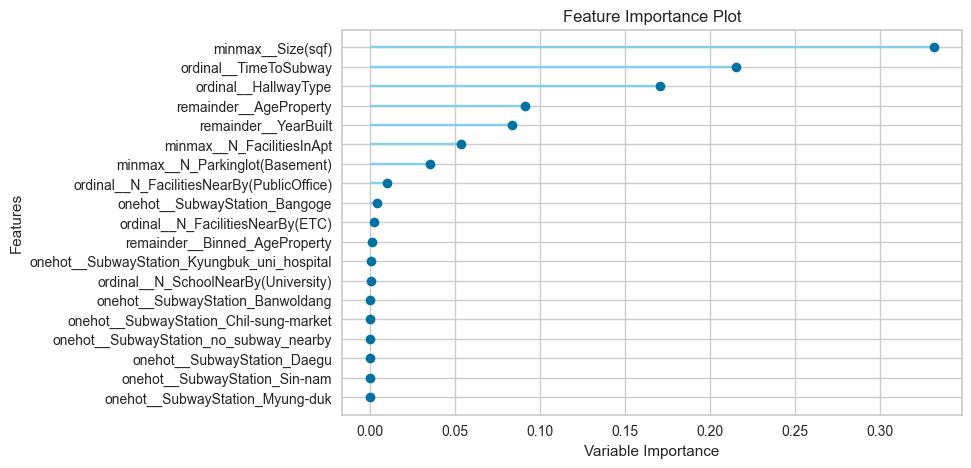

In [54]:
plot_model(finalmodel, plot = 'feature_all')

Impurity Based Feature Importance
Permutation Importance
Attribute Importance

Terlihat Bahwa Banyak Fitur yang tidak dianggap penting pada model ini maka diperlukan yang namanya permutation importance untuk menghandle hal ini.

- `Partial Dependence Plot`

In [55]:
interpret_model(result_gbr_sampling, plot = 'pdp')

- `Morris Sensitivity Analysis`

In [56]:
interpret_model(result_gbr_sampling, plot = 'msa')

- `Permutation Feature Importance`

In [57]:
interpret_model(result_gbr_sampling, plot = 'pfi')

19it [00:00, 178.62it/s]


##### 5. Result (Test With Validation Data)

In [58]:
# # Combine Train and Validation Data
# seen = train.append(val)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,38955.0886,2318710249.1415,48152.9880,0.7944,0.2264,0.1925


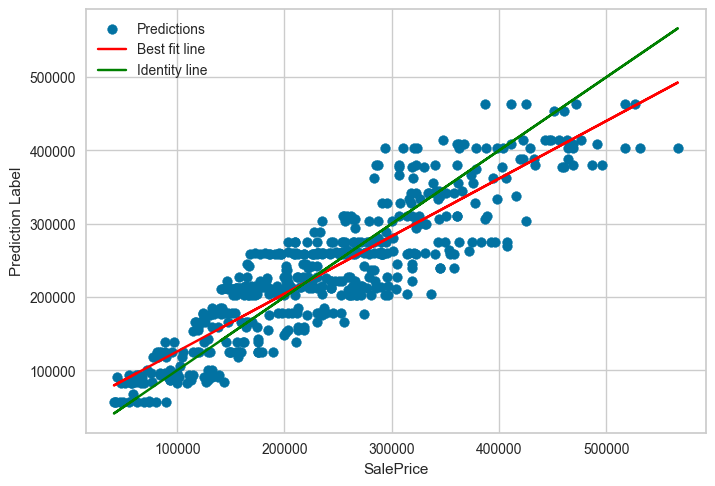

Maximum Value Error Difference From Actual Prize = 163256.46566507232
Most Tiny Positive Difference:  221.4656650723191
Most Tiny Negative Difference:  -1.0418343823694158
Minimum Value Error Difference From Actual Prize = -109876.53433492768
Many Data Overfitting = 253
Many Data Underfitting = 270
Many Data Predicted Correctly = 0


In [59]:
# Assuming finalmodel is already defined
predictions = predict_model(finalmodel, verbose=True, data=val)

# Scatter plot
plt.scatter(predictions['SalePrice'], predictions['prediction_label'])

# Best fit line
slope, intercept = np.polyfit(predictions['SalePrice'], predictions['prediction_label'], 1)
plt.plot(predictions['SalePrice'], slope*predictions['SalePrice'] + intercept, color='red')

# Identity line
plt.plot(predictions['SalePrice'], predictions['SalePrice'], color='green')

plt.legend(['Predictions', 'Best fit line', 'Identity line'])
plt.xlabel('SalePrice')
plt.ylabel('Prediction Label')
plt.show()

different = predictions['SalePrice'] - predictions['prediction_label']
positive_differences = different[different > 0]
negative_differences = different[different < 0]
print(f"Maximum Value Error Difference From Actual Prize = {different.max()}")
print("Most Tiny Positive Difference: ", positive_differences.min())
print("Most Tiny Negative Difference: ", negative_differences.max())
print(f"Minimum Value Error Difference From Actual Prize = {different.min()}")
print(f"Many Data Overfitting = {positive_differences.count()}")
print(f"Many Data Underfitting = {negative_differences.count()}")
print(f"Many Data Predicted Correctly = {null_differences.count()}")

plot sebar dengan Harga Jual aktual pada sumbu x dan label prediksi pada sumbu y. Mereka juga menyertakan garis yang paling sesuai dan garis identitas. Titik-titik yang berada pada garis identitas melambangkan prediksi yang sempurna. Semakin dekat garis paling cocok dengan garis identitas, semakin baik prediksi modelnya.

# **Implementation**

### Prediction Result (With Unseen Data)

In [60]:
# # Combine Seen With Unseen Data
# all_data = seen.append(unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,37283.6319,2179560220.2231,46685.7604,0.8112,0.2258,0.1895


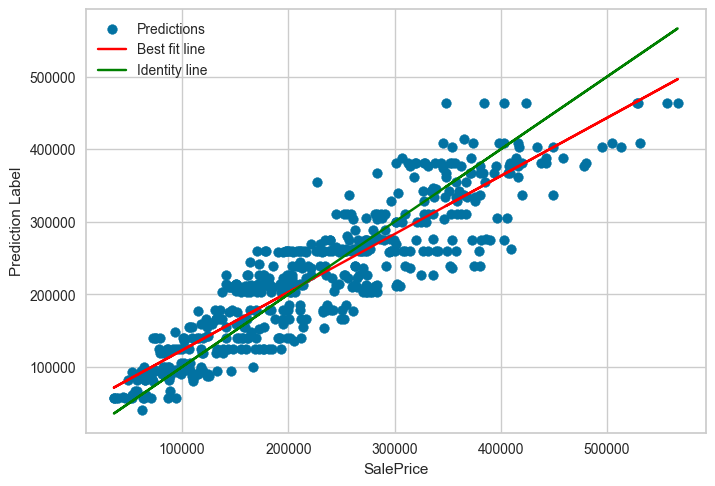

Maximum Value Error Difference From Actual Prize = 147235.54950731224
Most Tiny Positive Difference:  53.31586850210442
Most Tiny Negative Difference:  -48.648668760492
Minimum Value Error Difference From Actual Prize = -128762.15302133397
Many Data Overfitting = 246
Many Data Underfitting = 277
Many Data Predicted Correctly = 0


In [61]:
# Assuming finalmodel is already defined
predictions = predict_model(finalmodel, verbose=True, data=unseen)

# Scatter plot
plt.scatter(predictions['SalePrice'], predictions['prediction_label'])

# Best fit line
slope, intercept = np.polyfit(predictions['SalePrice'], predictions['prediction_label'], 1)
plt.plot(predictions['SalePrice'], slope*predictions['SalePrice'] + intercept, color='red')

# Identity line
plt.plot(predictions['SalePrice'], predictions['SalePrice'], color='green')

plt.legend(['Predictions', 'Best fit line', 'Identity line'])
plt.xlabel('SalePrice')
plt.ylabel('Prediction Label')
plt.show()

different = predictions['SalePrice'] - predictions['prediction_label']
positive_differences = different[different > 0]
negative_differences = different[different < 0]
print(f"Maximum Value Error Difference From Actual Prize = {different.max()}")
print("Most Tiny Positive Difference: ", positive_differences.min())
print("Most Tiny Negative Difference: ", negative_differences.max())
print(f"Minimum Value Error Difference From Actual Prize = {different.min()}")
print(f"Many Data Overfitting = {positive_differences.count()}")
print(f"Many Data Underfitting = {negative_differences.count()}")
print(f"Many Data Predicted Correctly = {null_differences.count()}")

plot sebar dengan Harga Jual aktual pada sumbu x dan label prediksi pada sumbu y. Mereka juga menyertakan garis yang paling sesuai dan garis identitas. Titik-titik yang berada pada garis identitas melambangkan prediksi yang sempurna. Semakin dekat garis paling cocok dengan garis identitas, semakin baik prediksi modelnya.

### Analysis For Business Perspective


Berdasarkan pemahaman bisnis yang telah diberikan, kita dapat melakukan analisis lebih lanjut terkait hasil prediksi yang dihasilkan oleh model Gradient Boosting Regressor untuk pasar real estat di Daegu. Berikut ini adalah interpretasi dari berbagai aspek evaluasi model:

- Learning Curve:

Kurva pembelajaran menunjukkan bahwa skor pelatihan stabil di angka tinggi, sedangkan skor validasi silang meningkat seiring dengan penambahan jumlah instansi pelatihan. Hal ini menandakan bahwa model terus meningkatkan kemampuan generalisasinya dengan penambahan data, yang mengindikasikan bahwa lebih banyak data pelatihan dapat membantu memperkecil kesenjangan prediksi.

- Residual Plot:

Plot residu menunjukkan adanya beberapa prediksi dengan residu tinggi (kesalahan prediksi yang besar), terutama pada harga properti yang tinggi. Ini mungkin mengindikasikan bahwa model kurang akurat dalam memprediksi properti dengan harga sangat tinggi atau sangat rendah, yang dapat berdampak pada kerugian penjual atau daya tarik pasar.

- Feature Importance:

Plot pentingnya fitur menunjukkan bahwa ukuran properti (Size) dan tahun pembangunan (YearBuilt) memiliki pengaruh signifikan terhadap prediksi harga. Informasi ini dapat digunakan oleh agen real estat untuk menekankan fitur-fitur ini saat memasarkan properti atau dalam negosiasi harga.
RFECV (Recursive Feature Elimination with Cross-Validation):

Diagram RFECV menunjukkan bahwa model mencapai performa optimal dengan 19 fitur. Hal ini menandakan bahwa model tidak memerlukan semua fitur yang tersedia untuk melakukan prediksi yang akurat, membantu mengurangi kompleksitas model dan waktu pelatihan.
Dari perspektif bisnis, berikut adalah beberapa analisis yang dapat dilakukan berdasarkan hasil model:

- Analisis Keuntungan:

Efisiensi Waktu:
Penggunaan model prediksi harga yang akurat dapat menghemat waktu agen, memungkinkan penentuan harga yang lebih cepat dan penanganan lebih banyak klien.
Penentuan Harga yang Tepat:
Model membantu agen menetapkan harga jual yang kompetitif, meningkatkan peluang penjualan dan kepuasan pelanggan.
Pelayanan Klien yang Lebih Baik:
Agen dapat memberikan konsultasi yang didukung data kepada klien, meningkatkan kepercayaan dan kepuasan pelanggan.
Keputusan Berbasis Data:
Mengurangi ketergantungan pada intuisi dengan keputusan yang lebih objektif dan berbasis data.

- Analisis Kerugian:

Tingkat Ketidakpastian:
Kesalahan prediksi (seperti MAPE 19.31%) menunjukkan adanya ketidakpastian dalam penetapan harga.
Keterbatasan Data:
Model mungkin tidak dapat memprediksi harga dengan akurat untuk properti yang unik atau di luar jangkauan data pelatihan.
Perubahan Pasar:
Model mungkin tidak responsif terhadap perubahan pasar yang cepat.
Analisis Investasi:

Investor dapat membuat keputusan investasi yang lebih tepat dengan memahami fitur-fitur yang mempengaruhi harga properti.
Analisis Pengembangan Properti:

Pembangun dapat menggunakan wawasan dari model untuk meningkatkan nilai jual proyek baru dengan menyesuaikan fitur-fitur yang dihargai oleh pasar.
Sebagai kesimpulan, model prediksi harga ini dapat menjadi alat berharga bagi agen real estat di Daegu untuk menginformasikan strategi penetapan harga dan menanggapi dinamika pasar. Penting untuk terus memantau performa model dan menyesuaikannya dengan data pasar terkini agar tetap akurat. 

# **Conclusion**

### Result Model Overall

- Secara Umum Model Sudah Mencapai Target Yang Diharapkan dengan MAE kurang dari 40.000 akan tetapi masih banyak data yang terprediksi dengan error lebih dari 40.000 won yang seharusnya bisa dikembangkan lebih lanjut.
- Test Pada Train Data Model Cenderung overfitting sedangkan untuk test pada seen dan unseen data cenderung underfitting.

### Recommendation

- Tingkatkan Proses Data Collection yang berkualitas karena beberapa fitur banyak duplikasi dan anomali
- Tingkatkan Proses Feature Engineering karena hasil modelnya masih cenderung overfitting
- Tingkatkan Proses Data Cleaning karena masih banyak data yang tidak terhandle dengan baik

# **Deployment**

Save Model As Pickle File

In [62]:
# Save As Pickle File
import pickle

with open('gbr_finalmodel.sav', 'wb') as file:
    pickle.dump(finalmodel, file)

Next Will Be At Deploy.py